In [1]:
from astropy.table import Table
from astropy.io import fits
from astropy.nddata.utils import Cutout2D
from astropy.visualization import make_lupton_rgb

from glob import glob
import sys

sys.path.append('../')
from source_names_dict import source_names_dict, source_names_readable
from get_closest_srcreg import read_region_file

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.gridspec as gridspec

from astropy.coordinates import SkyCoord
from astropy.wcs.utils import skycoord_to_pixel
from astropy.wcs import WCS
from astropy.io import fits
from astroquery.simbad import Simbad
import astropy.units as u
from get_all_region_files import get_all_regions
from astropy.nddata import Cutout2D
from astropy.nddata.utils import NoOverlapError
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [2]:
hdul1 = fits.open('../download_scripts/NGC1313/sky_img_ubb.img')
hdul2 = fits.open('../download_scripts/NGC1313/sky_img_um2.img')
hdul3 = fits.open('../download_scripts/NGC1313/sky_img_uuu.img')
hdul4 = fits.open('../download_scripts/NGC1313/sky_img_uvv.img')
hdul5 = fits.open('../download_scripts/NGC1313/sky_img_uw1.img')
hdul6 = fits.open('../download_scripts/NGC1313/sky_img_uw2.img')

In [3]:
s = Simbad()
source = s.query_object('NGC1313')
sc = SkyCoord(source['RA'], source['DEC'], unit=(u.hourangle, u.deg))
sc

<SkyCoord (ICRS): (ra, dec) in deg
    [(49.56685833, -66.49826111)]>

In [4]:
def get_cutout(hdul, sc, cutout_size=200):
    xpos, ypos = skycoord_to_pixel(sc, WCS(hdul[1].header))
    pos  = (xpos[0], ypos[0])
    cutout = Cutout2D(hdul[1].data, pos, cutout_size, wcs=WCS(hdul[1].header))
    return cutout

In [5]:
c1 = get_cutout(hdul1, sc)
c2 = get_cutout(hdul2, sc)
c3 = get_cutout(hdul3, sc)
c4 = get_cutout(hdul4, sc)
c5 = get_cutout(hdul5, sc)
c6 = get_cutout(hdul6, sc)

c1_s = c1.data / c1.data.max()
c2_s = c2.data / c2.data.max()
c3_s = c3.data / c3.data.max()
c4_s = c4.data / c4.data.max()
c5_s = c5.data / c5.data.max()
c6_s = c6.data / c6.data.max()

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 53907.103819 from DATE-OBS.
Set MJD-END to 56216.560394 from DATE-END'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 53907.103819 from DATE-OBS.
Set MJD-END to 56216.560394 from DATE-END'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 53907.112153 from DATE-OBS.
Set MJD-END to 57986.055509 from DATE-END'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 53907.112153 from DATE-OBS.
Set MJD-END to 57986.055509 from DATE-END'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 53907.102407 from DATE-OBS.
Set MJD-END to 59480.665926 from DATE-END'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 53907.102407 from DATE-OBS.
Set MJD-END to 59480.665

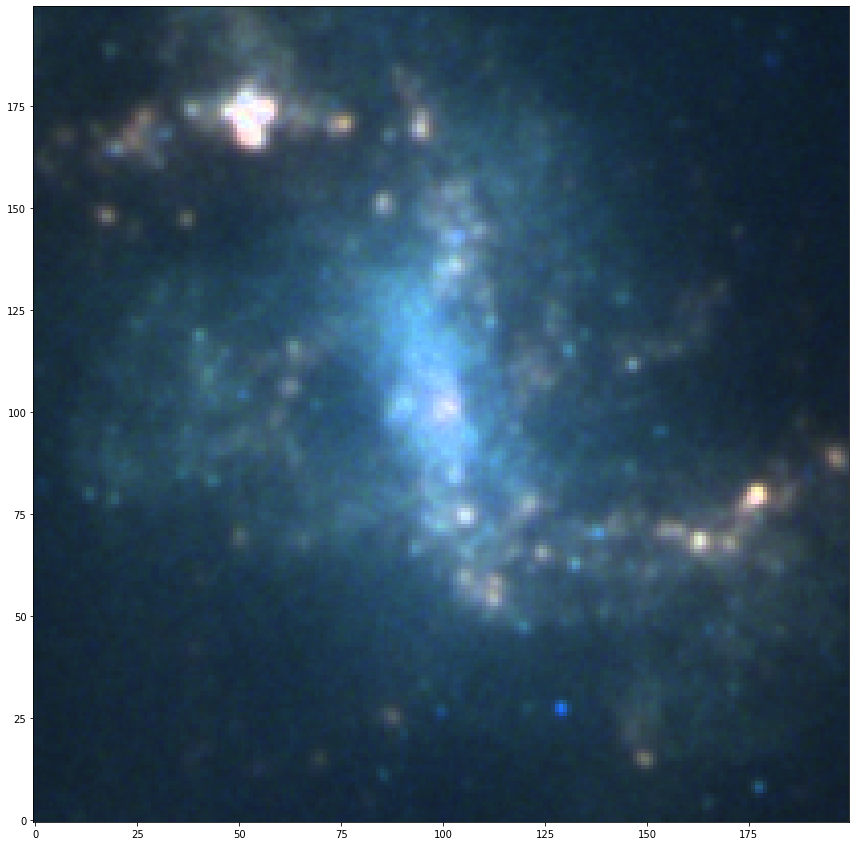

In [6]:
stack = make_lupton_rgb(c3_s, c1_s, c4_s, stretch=0.5, minimum=0.0, Q=0.001)
plt.figure(figsize=(15,15))
plt.imshow(stack, origin='lower', interpolation='none')

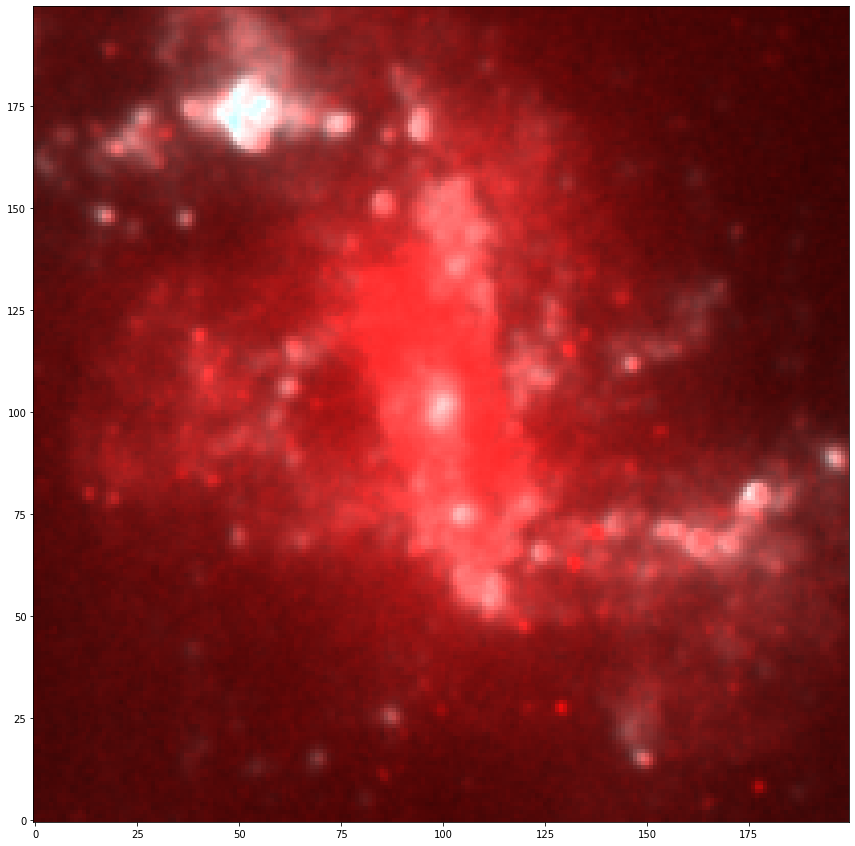

In [7]:
stack = make_lupton_rgb(c1_s, c6_s, c2_s, stretch=0.25, minimum=0.0, Q=1e-8)
plt.figure(figsize=(15,15))
plt.imshow(stack, origin='lower', interpolation='none')

In [8]:
stack.shape

(200, 200, 3)

In [9]:
def wavelength_to_rgb(wavelength, gamma=0.8):

    '''This converts a given wavelength of light to an 
    approximate RGB color value. The wavelength must be given
    in nanometers in the range from 380 nm through 750 nm
    (789 THz through 400 THz).
    Based on code by Dan Bruton
    http://www.physics.sfasu.edu/astro/color/spectra.html
    '''

    wavelength = float(wavelength)
    if wavelength >= 380 and wavelength <= 440:
        attenuation = 0.3 + 0.7 * (wavelength - 380) / (440 - 380)
        R = ((-(wavelength - 440) / (440 - 380)) * attenuation) ** gamma
        G = 0.0
        B = (1.0 * attenuation) ** gamma
    elif wavelength >= 440 and wavelength <= 490:
        R = 0.0
        G = ((wavelength - 440) / (490 - 440)) ** gamma
        B = 1.0
    elif wavelength >= 490 and wavelength <= 510:
        R = 0.0
        G = 1.0
        B = (-(wavelength - 510) / (510 - 490)) ** gamma
    elif wavelength >= 510 and wavelength <= 580:
        R = ((wavelength - 510) / (580 - 510)) ** gamma
        G = 1.0
        B = 0.0
    elif wavelength >= 580 and wavelength <= 645:
        R = 1.0
        G = (-(wavelength - 645) / (645 - 580)) ** gamma
        B = 0.0
    elif wavelength >= 645 and wavelength <= 750:
        attenuation = 0.3 + 0.7 * (750 - wavelength) / (750 - 645)
        R = (1.0 * attenuation) ** gamma
        G = 0.0
        B = 0.0
    else:
        R = 0.0
        G = 0.0
        B = 0.0
    R *= 255
    G *= 255
    B *= 255
    return (int(R)/256, int(G)/256, int(B)/256)

In [10]:
# UVOT central wavelength (nm)
nm_v 	= 546.8
nm_b 	= 439.2
nm_u 	= 346.5
nm_uvw1 = 260.0
nm_uvm2 = 224.6
nm_uvw2 = 192.8

In [11]:
b = 380 - ((750-380) / (546.8-192.8)) * 192.8
a = (750-380) / (546.8-192.8)

nm_v 	= 546.8
nm_b 	= 439.2
nm_u 	= 346.5
nm_uvw1 = 260.0
nm_uvm2 = 224.6
nm_uvw2 = 192.8


vis_v 	 = a*nm_v 	+b
vis_b 	 = a*nm_b 	+b
vis_u 	 = a*nm_u 	+b
vis_uvw1 = a*nm_uvw1+b
vis_uvm2 = a*nm_uvm2+b
vis_uvw2 = a*nm_uvw2+b

wls = np.array([vis_v,vis_b,vis_u,vis_uvw1,vis_uvm2,vis_uvw2])

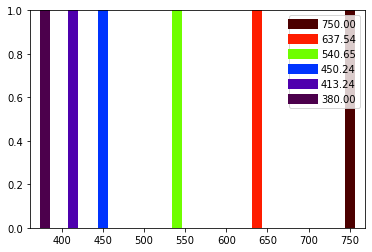

In [12]:
for wl in wls:
    rgb = wavelength_to_rgb(wl, gamma=1.0)
    plt.axvline(wl, color=rgb, linewidth=10, label=f'{wl:.2f}')
plt.legend()

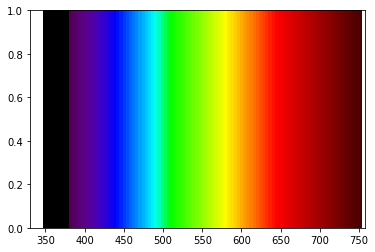

In [13]:
for wl in np.linspace(350,750,100):
    rgb = wavelength_to_rgb(wl, gamma=1.0)
    plt.axvline(wl, color=rgb, linewidth=5)

In [14]:
stackk = np.dstack([c1_s, c2_s, c3_s, c4_s, c5_s, c6_s])
stackk

array([[[0.07343582, 0.00706072, 0.03816675, 0.10345323, 0.01180009,
         0.00706071],
        [0.07308578, 0.00713282, 0.03817081, 0.10278899, 0.01194075,
         0.00713282],
        [0.07033388, 0.00680247, 0.03802482, 0.10123766, 0.01226067,
         0.00680247],
        ...,
        [0.06203408, 0.00656824, 0.03570854, 0.10259955, 0.01122781,
         0.00656823],
        [0.0613877 , 0.00710643, 0.03570567, 0.08563   , 0.01205814,
         0.00710642],
        [0.06546709, 0.00795457, 0.03634186, 0.0858914 , 0.01293011,
         0.00795457]],

       [[0.0753489 , 0.00713676, 0.03809869, 0.10005982, 0.01261889,
         0.00713676],
        [0.07929356, 0.00700152, 0.03779316, 0.09719976, 0.01239565,
         0.00700152],
        [0.07942819, 0.00677662, 0.03759137, 0.09932619, 0.01211371,
         0.00677661],
        ...,
        [0.06379641, 0.00704524, 0.03554852, 0.11146462, 0.01127656,
         0.00704524],
        [0.06907985, 0.0073139 , 0.03579205, 0.10241095, 0.011

In [17]:
pixel_values = stackk[0][0]
pixel_values

array([0.07343582, 0.00706072, 0.03816675, 0.10345323, 0.01180009,
       0.00706071], dtype=float32)

In [ ]:
pixel_values_weight = pixel_values / pixel_values.sum()
pixel_values_weight

In [ ]:
wls

In [ ]:
average_wl = (pixel_values_weight*wls).sum()
average_wl

In [ ]:
pixel_values_weight = pixel_values_weight * pixel_values
pixel_values_weight

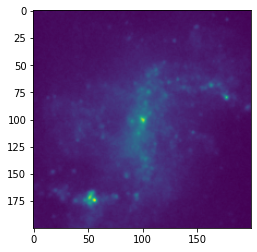

In [23]:
plt.imshow(c1_s)

In [32]:
# For each pixel calculate the relative weights of each band
c1_weight = c1_s / np.sum([c1_s,c2_s,c3_s,c4_s,c5_s,c6_s], axis=0)
c2_weight = c2_s / np.sum([c1_s,c2_s,c3_s,c4_s,c5_s,c6_s], axis=0)
c3_weight = c3_s / np.sum([c1_s,c2_s,c3_s,c4_s,c5_s,c6_s], axis=0)
c4_weight = c4_s / np.sum([c1_s,c2_s,c3_s,c4_s,c5_s,c6_s], axis=0)
c5_weight = c5_s / np.sum([c1_s,c2_s,c3_s,c4_s,c5_s,c6_s], axis=0)
c6_weight = c6_s / np.sum([c1_s,c2_s,c3_s,c4_s,c5_s,c6_s], axis=0)


In [57]:
wls

array([750.        , 637.53672316, 540.64689266, 450.23728814,
       413.23728814, 380.        ])

In [66]:
# For each pixel calculate the average wavelength based on the weights
weight_stack = np.dstack([c1_weight,c2_weight,c3_weight,c4_weight,c5_weight,c6_weight])
wls_stack = weight_stack * wls
wls_stack

array([[[228.55623811,  18.68004363,  85.62936375, 193.28999881,
          20.23524895,  11.13412406],
        [228.15352678,  18.92777255,  85.89702515, 192.62876743,
          20.53829168,  11.28178425],
        [224.02940691,  18.41837341,  87.3092081 , 193.58102435,
          21.51755933,  10.97815495],
        ...,
        [207.05039799,  18.63538871,  85.91525648, 205.57553264,
          20.64804526,  11.10750917],
        [220.29675543,  21.67813077,  92.36690804, 184.47300793,
          23.84214155,  12.92111054],
        [226.7498374 ,  23.41987477,  90.73681919, 178.58862698,
          24.6754113 ,  13.95927526]],

       [[235.0736931 ,  18.92658861,  85.68199534, 187.39890881,
          21.69134083,  11.28107715],
        [247.08699435,  18.54591973,  84.8941247 , 181.82656617,
          21.28234999,  11.05418809],
        [246.14882469,  17.8517128 ,  83.97764383, 184.785167  ,
          20.68419875,  10.64040236],
        ...,
        [202.59124786,  19.01797422,  81.3763

In [82]:
# Get wavelength at every pixel
pixel_wls = wls_stack.sum(axis=-1)
pixel_wls

array([[557.52501733, 557.42716785, 555.83372704, ..., 548.93213025,
        555.57805426, 558.1298449 ],
       [560.05360383, 564.69014303, 564.08794943, ..., 546.54325995,
        554.48952864, 558.93234045],
       [554.17604454, 555.33458293, 555.41825829, ..., 551.23539922,
        549.69401916, 551.21549607],
       ...,
       [557.46035699, 552.89922426, 554.11904692, ..., 555.85687046,
        558.49113714, 556.02291921],
       [553.33879599, 555.63044384, 552.14307424, ..., 561.71853981,
        562.59256702, 557.74332705],
       [557.64711247, 557.47857979, 553.61972663, ..., 553.52113207,
        553.70281607, 549.5744011 ]])

In [151]:
# calculate rbg at every pixel
pixel_wls

array([[557.52501733, 557.42716785, 555.83372704, ..., 548.93213025,
        555.57805426, 558.1298449 ],
       [560.05360383, 564.69014303, 564.08794943, ..., 546.54325995,
        554.48952864, 558.93234045],
       [554.17604454, 555.33458293, 555.41825829, ..., 551.23539922,
        549.69401916, 551.21549607],
       ...,
       [557.46035699, 552.89922426, 554.11904692, ..., 555.85687046,
        558.49113714, 556.02291921],
       [553.33879599, 555.63044384, 552.14307424, ..., 561.71853981,
        562.59256702, 557.74332705],
       [557.64711247, 557.47857979, 553.61972663, ..., 553.52113207,
        553.70281607, 549.5744011 ]])

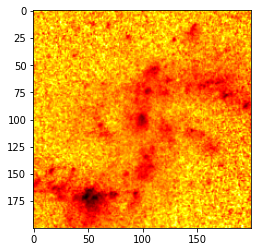

In [169]:
plt.imshow(pixel_wls, cmap='hot')

In [162]:
v_wavelength_to_rgb = np.vectorize(wavelength_to_rgb)
pixel_rgbs = np.array(v_wavelength_to_rgb(pixel_wls)).T

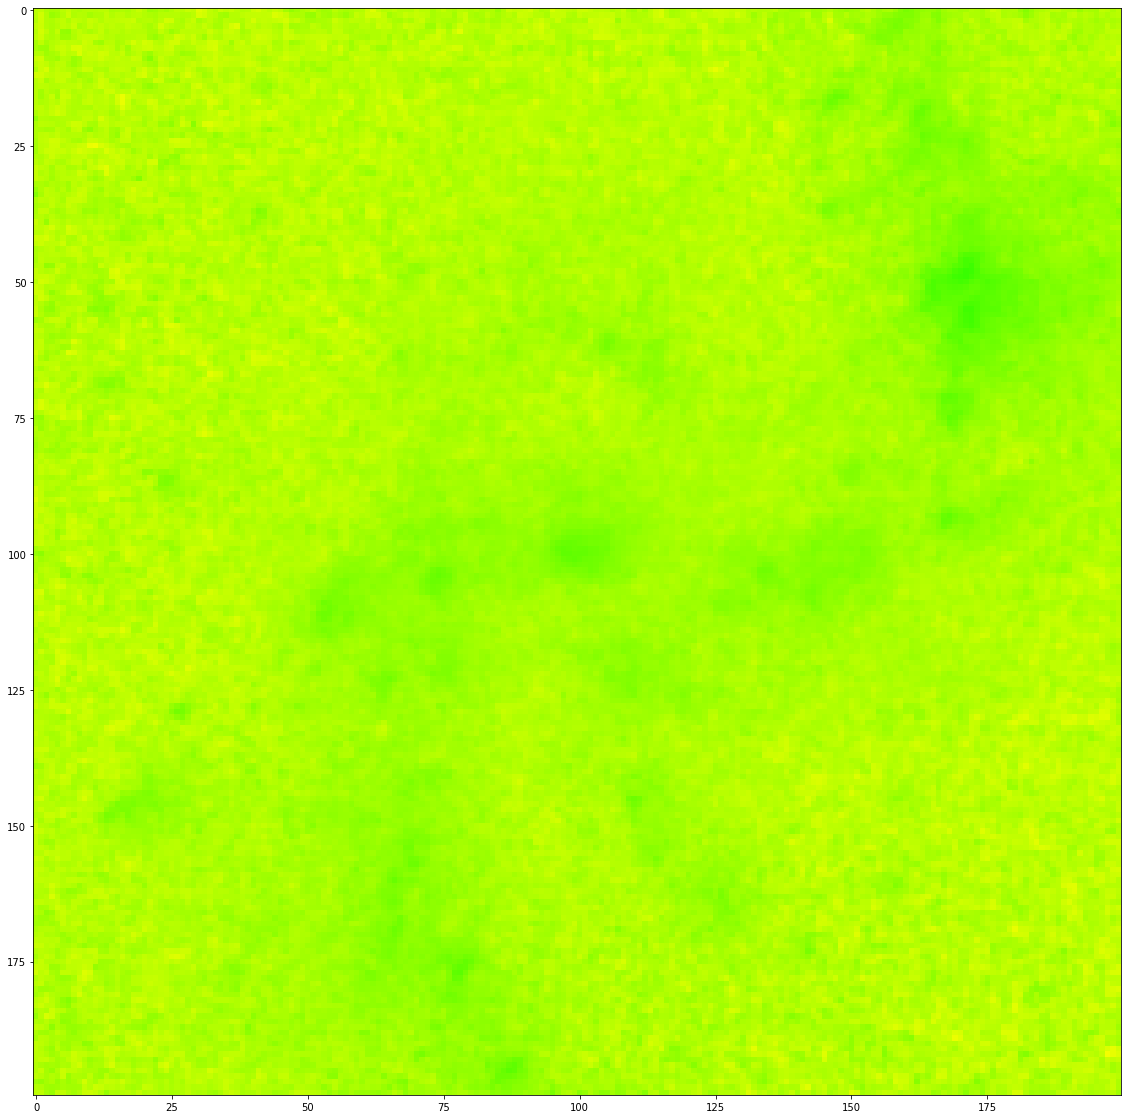

In [167]:
plt.figure(figsize=(20,20))
plt.imshow(pixel_rgbs, interpolation='none')